# 2 Portfolio consruction interactively

##### Goal: User can change parameters in a box below. Then observe the performance of the stock portfolio. The strategy is 'healthy reversal' which aims to pick stocks experiencing price decline, but that are healthy otherwise. Parameters that can be changed: upper quantile of previous returns, minimum EBIT margin, and minimum revenue growth.  <br>
Data - in this notebook is downloaded from Dropbox. The code for obtaining data is run in notebook 'Plot1_featured_predictive_model' 

 ++++++++++++++++++++++++++++++++++++++++++++ <br>
 By: Yuriy Podvysotskiy <br>
 Date: November 4, 2019 <br>
 ++++++++++++++++++++++++++++++++++++++++++++

In [52]:
# Import packages:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [53]:
# Get the collected data:
id1 = "https://www.dropbox.com/s/x0tzza87nrie9rr/SP100_panel.csv?dl=1"
id2 = "https://www.dropbox.com/s/nmyyrs7yehh7gdo/SP100.csv?dl=1"

df_panel = pd.read_csv(id1)
df_mkt = pd.read_csv(id2)


In [54]:
# Function for making analysis (run it)
def backtest_strategy(df_panel, df_mkt, ret_quant, low_ebitm, low_revg):
    df_panel['ret_bottom'] = 0
    df_panel['return'] = df_panel['return'].fillna(0)
    
    quantiles = df_panel.groupby(['date'])['return'].quantile(ret_quant)
    quantiles = pd.DataFrame(quantiles)
    quantiles.columns = ['low_quantile']
    
    quantiles['date'] = quantiles.index
    quantiles = quantiles.reset_index(drop = True)
    
    df_panel = df_panel.merge(quantiles, how = 'left', on = ['date'])
    df_panel['low_quantile'].describe()
    
    df_panel.loc[df_panel['return'] <= df_panel['low_quantile'],'ret_bottom'] = 1
    
    df_panel['perf_well'] = 0
    df_panel.loc[(df_panel['ebitm'] > low_ebitm) & (df_panel['revg'] > low_revg), 'perf_well'] = 1
    
    df_panel['chosen'] = df_panel['ret_bottom'] * df_panel['perf_well']
    df_panel[['ret_bottom', 'perf_well', 'chosen']].describe()
    
    df_panel = df_panel.sort_values(by = ['ticker', 'date'])
    df_panel = df_panel.reset_index(drop = True)
    
    df_panel['chosen1'] = df_panel.groupby(['ticker'])['chosen'].shift(1)
    
    
    # 2) ******************** test strategy *************************************
    ## 2.1) pick all stocks that correspond to the rule
    n_sums = df_panel.groupby(['date'])['chosen1'].sum()
    n_sums = pd.DataFrame(n_sums)
    n_sums.columns = ['n_sum']
    
    n_sums['date'] = n_sums.index
    n_sums = n_sums.reset_index(drop = True)
    
    df_panel = df_panel.merge(n_sums, how = 'left', on = ['date'])
  
    df_panel['portf_ret'] = df_panel['return'] * df_panel['chosen1'] / df_panel['n_sum']
    df_panel['portf_ret'] = df_panel['portf_ret'].fillna(0)
    
    df_panel = df_panel[['date', 'portf_ret']]
    df_panel = df_panel.dropna()
    
    df_portf = df_panel.groupby(['date']).sum()
    df_portf['date'] = df_portf.index
    df_portf = df_portf.reset_index(drop = True)
    df_portf = df_portf.merge(df_mkt, on = ['date'])
    df_portf = df_portf.fillna(method = 'ffill')
    df_portf = df_portf.sort_values(by = ['date'])
    df_portf = df_portf.reset_index(drop = True)
    
    df_portf['portf_cumret'] = df_portf['portf_ret'].cumsum()
    df_portf['mkt_cumret'] = df_portf['mkt_ret'].cumsum()
    return(df_portf)


Comment: 

 The user can change the three parameters above, 
  and observe the change in the dynamics of the portfolio peformance versus the relevant market index. 
 Also, below is the quantitative evaluation based on the key investment performance metrics (Sharpe, Alpha, and Beta).


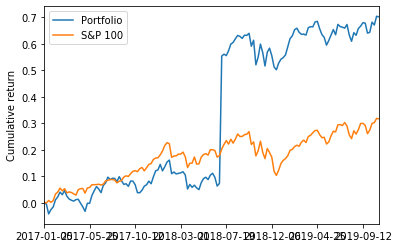

In [64]:
# User parameters (please change!):
ret_quant0 = 0.25  # pick stocks with returns below given quantile (for reversion strategy)
low_ebitm0 = 0.1   # pick stocks with ebit margin above given threshold
low_revg0 = 0.05   # pick stocks with revenue growth above certain threshold

# ----------------------------------------------------------------------
# Run the portfolio formation:
df_portf = backtest_strategy(df_panel, df_mkt, 
                             ret_quant = ret_quant0, low_ebitm = low_ebitm0, low_revg = low_revg0)

print("Comment: \n\n", "The user can change the three parameters above, \n", 
      " and observe the change in the dynamics of the portfolio peformance versus the relevant market index. \n", 
     "Also, below is the quantitative evaluation based on the key investment performance metrics (Sharpe, Alpha, and Beta).")

# And see the portfolio performance vs. the parket:
ax = df_portf.plot(x = "date", y = ['portf_cumret', 'mkt_cumret'])
ax.set_ylabel("Cumulative return")
ax.set_xlabel("")
ax.legend(["Portfolio", "S&P 100"])

In [63]:
# Evaluation of portfolio versus the market:
from sklearn.linear_model import LinearRegression

## Indicators:  Ann_ret, Ann_sd, Sharpe, Alpha, Beta
## For:         Portfolio, Market 

portf_Y = df_portf['portf_ret']
portf_X = df_portf['mkt_ret']

reg_p = LinearRegression().fit(portf_X.values.reshape(-1, 1), portf_Y.values.reshape(-1, 1))

df_perf1 = pd.DataFrame( columns = ['Portfolio', 'Market'], 
                       index = ['return', 'st dev', 'sharpe', 'alpha', 'beta'])

df_perf1.loc['return', 'Portfolio'] = "{:.4f}".format(df_portf['portf_ret'].mean()*51)
df_perf1.loc['st dev', 'Portfolio'] = "{:.4f}".format(df_portf['portf_ret'].std()*(51**0.5))
df_perf1.loc['sharpe', 'Portfolio'] = "{:.4f}".format((df_portf['portf_ret'].mean()*51 - .02)/(df_portf['portf_ret'].std()*(51**0.5)))
df_perf1.loc['alpha', 'Portfolio'] = "{:.4f}".format(reg_p.intercept_[0]*51)
df_perf1.loc['beta', 'Portfolio'] = "{:.4f}".format(reg_p.coef_[0][0])

df_perf1.loc['return', 'Market'] = "{:.4f}".format(df_portf['mkt_ret'].mean()*51)
df_perf1.loc['st dev', 'Market'] = "{:.4f}".format(df_portf['mkt_ret'].std()*(51**0.5))
df_perf1.loc['sharpe', 'Market'] = "{:.4f}".format((df_portf['mkt_ret'].mean()*51 - .02)/ (df_portf['mkt_ret'].std()*(51**0.5)))
df_perf1.loc['alpha', 'Market'] = "{:.4f}".format(0)
df_perf1.loc['beta', 'Market'] = "{:.4f}".format(1)

print("Comment: \n\n", "The constructed portoflio has higher annualized return, but also higher risk. \n",
      "Its risk-adjusted return (Alpha) is positive 10.1% on annualized basis. \n", 
     "Sharpe ratio is worse than that of the market. \n\n",
     "BUT","the goal here is to design user-interaction system. Which can then be used for constructing superior portfolios.")

df_perf1

Comment: 

 The constructed portoflio has higher annualized return, but also higher risk. 
 Its risk-adjusted return (Alpha) is positive 10.1% on annualized basis. 
 Sharpe ratio is worse than that of the market. 

 BUT the goal here is to design user-interaction system. Which can then be used for constructing superior portfolios.


,Portfolio,Market
return,0.2415,0.1092
st dev,0.3200,0.1190
sharpe,0.6923,0.7499
alpha,0.1010,0.0000
beta,1.2862,1.0000
